## SOUMAHORO Youssouf
## Enseignant: Olaf KOUAMO


### TP: Titanic
        objectif: mettre en place un modèle de machine learning pour prédire les survivants au naufrage 
        du Titanic

In [1]:
import pandas as pd
import numpy as np

### 1. Lecture des données

In [2]:
train = pd.read_csv("data/train.csv", sep=',')
#train.set_index("PassengerId", inplace=True, drop=True)
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# overview of the problem and define candidates to modelisation
train.dtypes, train.count()

(PassengerId      int64
 Survived         int64
 Pclass           int64
 Name            object
 Sex             object
 Age            float64
 SibSp            int64
 Parch            int64
 Ticket          object
 Fare           float64
 Cabin           object
 Embarked        object
 dtype: object, PassengerId    891
 Survived       891
 Pclass         891
 Name           891
 Sex            891
 Age            714
 SibSp          891
 Parch          891
 Ticket         891
 Fare           891
 Cabin          204
 Embarked       889
 dtype: int64)

Avant de construire notre modèle, nous allons remplacer les valeurs manquantes dans les variables soit par la mediane ou le mode selon qu'elles soient continues ou qualitatives

In [33]:
# Fonction permettant de remplacer les values manquantes
def imput_missing_values(df):
    # Remplacer les variables (quali ou quanti) par le mode ou la mediane
    
    for col in list(df.columns):
        if(df[col].dtypes == int or df[col].dtypes == float):
            df[col] = df[col].fillna(df[col].median())
        if (df[col].dtypes == object):
            df[col] = df[col].fillna(df[col].mode()[0])

Appliquons cette fonction à notre jeu de donnéés

In [34]:
imput_missing_values(train)

### 2. quick modelisation: logistics Regression 



Nous allons maintenant identifier les variables et le target que nous voulons utiliser pour lancer notre premier modèle

In [90]:
def parse_model(X, use_columns):
    if "Survived" not in X.columns:
        raise ValueError("target column survived should belong to df")
    target = X["Survived"]
    X = X[use_columns]
    return X, target

model_cols1 =['SibSp', 'Parch', 'Fare']
X, y = parse_model(X=train.copy(), use_columns=model_cols1)

##### Note: For integer/None inputs, if the estimator is a classifier and y is either binary or multiclass, StratifiedKFold is used. In all other cases, KFold is used.

In [45]:
from sklearn.cross_validation import cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression

### Logistic Regression
    Nous allons spliter plusieurs fois notre jeu de données en train-test et ensuite ajuster notre 
    modèle de logistic à chaque fois nous retiendrons au final le score moyen à l'issue de ces 
    ajustements que nous comparerons au score moyen de la cross-validation

In [1]:
def compute_score(model,X,y,cv=5):
    """compute score in a classification modelisation.
       paramters
       -------------
       clf: classifier
       X: features
       y: target
       
       returns
       ------------
      dic_score: mean scores train_test
                mean score cross-validation
    """
    list_test_size = [a/20.0 for a in list(range(0,20,1))][1:]
    scores = []
    for ts in list_test_size:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=ts, random_state=0)
        clf = model.fit(X_train, y_train)
        scores.append(clf.score(X_test, y_test))
        
    sc = round(np.array(scores).mean(),2)
    xval = round(cross_val_score(clf, X, y, cv=5).mean(),2)
    
    dic_score = {'score_train_test_split':sc, 'score_cv':xval}
    
    return dic_score

#### Application de la fonction compute_score

In [77]:
lr = LogisticRegression()
compute_score(lr, X, y, cv=5)

{'score_cv': 0.67, 'score_train_test_split': 0.69}

ce score est proche de la moyenne de la vingtaine de tests de validation réalisée plus haut.
ce qui valide la pertinence de cette stratégie de cross validation.

### Etude des variables

In [47]:
survived = train[train.Survived == 1]
dead = train[train.Survived == 0]

Populating the interactive namespace from numpy and matplotlib


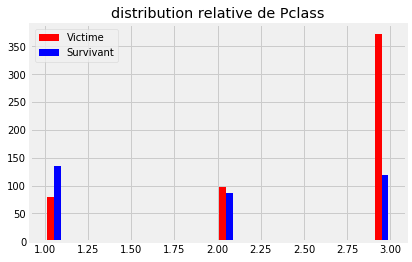

In [82]:
import matplotlib.pyplot as plt
from matplotlib import style
style.use('fivethirtyeight')
%matplotlib inline
%pylab inline


def plot_hist(feature, bins=20):
    x1 = np.array(dead[feature].dropna())
    x2 = np.array(survived[feature].dropna())
    plt.hist([x1, x2], label=["Victime", "Survivant"], bins=bins, color=['r', 'b'])
    plt.legend(loc="upper left")
    plt.title('distribution relative de %s' %feature)
    plt.show()
plot_hist('Pclass')

Pour ajouter une nouvelle variable qualitative à notre jeu de données d'apprentissage, il faut d'abord dummifier la variable pour qu'elle soit prise en compte par la regression logistique.
La fonction suivante nous permet de faire cela.

In [70]:
def dummify_features(X,to_dummify):
    """
    Transform categorical variables to dummy variables.

    Parameters
    ----------
    df: dataframe containing only categorical features

    Returns
    -------
    X: new dataframe with dummified features
       Each column name becomes the previous one + the modality of the feature
    """
    dummif = pd.get_dummies(train[to_dummify])
    dummif = dummif.rename(columns={i:to_dummify+"_"+str(i) \
                                    for i in list(dummif.columns)})
        
    return X.join(dummif)

Comme nous l'avions vu la fonction la variable **Pclass** est a une influence sur notre target **Survived** nous allons donc la dummifier la rajouter à notre jeu d'apprentissage.

In [91]:
X = dummify_features(X,"Pclass")
X.head()

,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3
0,1,0,7.2500,0,0,1
1,1,0,71.2833,1,0,0
2,0,0,7.9250,0,0,1
3,1,0,53.1000,1,0,0
4,0,0,8.0500,0,0,1


In [80]:
compute_score(lr, X, y)['score_cv']

0.69

On remarque que notre score s'est nettement amélioré après l'ajout la variables **Pclass**

- les femmes ont plus survécu au naufrage de les hommes il est donc intéressant qu'on regarde la
  variable **Sex**. Nous allons l'ajouter et voir l'évolution du score

In [92]:
X = dummify_features(X,'Sex')
X.head()

,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male
0,1,0,7.2500,0,0,1,0,1
1,1,0,71.2833,1,0,0,1,0
2,0,0,7.9250,0,0,1,1,0
3,1,0,53.1000,1,0,0,1,0
4,0,0,8.0500,0,0,1,0,1


In [86]:
compute_score(lr,X,y)['score_cv']

0.79

Encore une fois notre score s'est améliorer sensiblement

In [87]:
lr.fit(X, y)
coef = pd.DataFrame([list(X.columns), list(lr.coef_[0])])
coef

,0,1,2,3,4,5,6,7
0,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male
1,-0.252825,-0.0889732,0.00415096,0.729952,0.131395,-0.823605,1.36491,-1.32717


 Qu'en est-il de la variable **Age**.
 
 Ajoutons cette variable à notre ensemble X

In [93]:
X = X.join(train["Age"])

In [94]:
compute_score(lr,X,y)['score_cv']

0.79

le score n'a pas changé du tout. On peut donc dire que la variable **Age** en elle n'a aucune influence sur notre modèle. Ce qui est surprenant car on embarquait les enfants et les femmes d'abord.

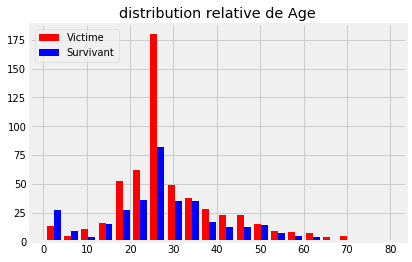

In [88]:
plot_hist('Age')

Comme on peut le contater, il y'a bcp de survivant chez les enfants. Ainsi nous allons créer une nouvelle variable as **is_child** qui prendra l'age des enfants.

In [96]:
train['is_child'] = (train["Age"] < 8).astype(int)

Ajoutons cette nouvelle variable à notre données de train X et ajustons à nouveau notre modèle

In [97]:
X = X.drop(["Age"],axis=1)
X = dummify_features(X,'is_child')
X.head()

,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,is_child_0,is_child_1
0,1,0,7.2500,0,0,1,0,1,1,0
1,1,0,71.2833,1,0,0,1,0,1,0
2,0,0,7.9250,0,0,1,1,0,1,0
3,1,0,53.1000,1,0,0,1,0,1,0
4,0,0,8.0500,0,0,1,0,1,1,0


In [98]:
compute_score(lr,X,y)['score_cv']

0.81

Nous pouvons constater une amélioration au niveau du score

- Intéressons maintenant à la civilité des personnes qui étaient à bord du Titanic. 

Cela va t-il influencer notre modèle? C'est ce qu'on essayera de voir. A cet effet nous allons écrire qui fonction qui va renvoyer la civilité des passagers selon qu'elle soit Mrs, Miss... et ensuite créer une nouvelle variable **Title** dans l'ensemble de données train

In [99]:
def getTitle(str):
    return str.split(",")[1].split(".")[0].strip()
train['Title'] = train["Name"].apply(lambda x:getTitle(x))

Rajoutons maintenant cette nouvelle variable à notre l'ensemble de données X et ajustons à nouveau le modèle

In [100]:
X = dummify_features(X,'Title')
X.head()

,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,is_child_0,is_child_1,...,Title_Master,Title_Miss,Title_Mlle,Title_Mme,Title_Mr,Title_Mrs,Title_Ms,Title_Rev,Title_Sir,Title_the Countess
0,1,0,7.2500,0,0,1,0,1,1,0,...,0,0,0,0,1,0,0,0,0,0
1,1,0,71.2833,1,0,0,1,0,1,0,...,0,0,0,0,0,1,0,0,0,0
2,0,0,7.9250,0,0,1,1,0,1,0,...,0,1,0,0,0,0,0,0,0,0
3,1,0,53.1000,1,0,0,1,0,1,0,...,0,0,0,0,0,1,0,0,0,0
4,0,0,8.0500,0,0,1,0,1,1,0,...,0,0,0,0,1,0,0,0,0,0


In [102]:
compute_score(lr,X,y)['score_cv']

0.82

Le score est passé de 0.81 à 0.82. Il y avait sans doute des starts dans le bateau qui sont répérer ici par leurs surnames ceci pourrait avoir une influence sur notre modèle. Nous allons créer à nouveau une variable **Surname** dans le jeu de données et voir son effet sur le modèle.

In [103]:
train["Surname"] = train["Name"].apply(lambda x : '(' in x).astype(int)
X = dummify_features(X,'Surname')
X.head()

,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,is_child_0,is_child_1,...,Title_Mlle,Title_Mme,Title_Mr,Title_Mrs,Title_Ms,Title_Rev,Title_Sir,Title_the Countess,Surname_0,Surname_1
0,1,0,7.2500,0,0,1,0,1,1,0,...,0,0,1,0,0,0,0,0,1,0
1,1,0,71.2833,1,0,0,1,0,1,0,...,0,0,0,1,0,0,0,0,0,1
2,0,0,7.9250,0,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,1,0
3,1,0,53.1000,1,0,0,1,0,1,0,...,0,0,0,1,0,0,0,0,0,1
4,0,0,8.0500,0,0,1,0,1,1,0,...,0,0,1,0,0,0,0,0,1,0


In [105]:
compute_score(lr,X,y)['score_cv']

0.83

### Modèles ensemblistes

    Découpage du jeu de données en train-test

In [108]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
print("train: ",X_train.shape)
print("test: ",X_test.shape)

train:  (623, 29)
test:  (268, 29)


### Random Forest

In [139]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

clf = RandomForestClassifier()


In [163]:
def compute_model(clf,X,y,test_size=0.3):
    """
    Compute model regression or ensemble.

    Parameters
    ----------
    clf: the classifier which must be defined before
    X  : predictors set
    y  : target

    Returns
    -------
    dic_score: contains precision, recall, accuracy of the model
    """
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=0)
    
    clf.fit(X_train,y_train)
    pred = clf.predict(X_test)

    prec = metrics.precision_score(y_test, pred)
    rec = metrics.recall_score(y_test, pred)
    acc = metrics.accuracy_score(y_test, pred)
    dic_score = {"precision":prec,"recall":rec, "acccuracy": acc }
    #dic_res = {"predictions":pred, "scores":dic_score}
    
    return dic_score
     

In [164]:
compute_model(clf,X,y)

{'acccuracy': 0.8283582089552238, 'precision': 0.78125, 'recall': 0.75}

In [172]:
def compute_girdSearch(clf,X,y,parameters,test_size=0.3,scoring="accuracy"):
    
    """
    Compute model regression or ensemble.

    Parameters
    ----------
    clf: the classifier which must be defined before
    X  : predictors set
    y  : target
    parameters: GridSearch's parameters

    Returns
    -------
     accuracy of the model
    """
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=0)
    grille = GridSearchCV(clf, param_grid=parameters, cv=5, scoring=scoring, verbose=0, n_jobs = 2)
    
    grille.fit(X_train,y_train)
    pred = grille.predict(X_test)
    
    return accuracy_score(pred,y_test)

In [173]:
parameters = [{'n_estimators':[100,200,300], 'max_depth':[5,10,20], 
               'min_samples_split':[10,20,25], 'min_samples_leaf':[5,10,15]}]

compute_girdSearch(clf,X,y,parameters,test_size=0.4)

0.803921568627451

In [166]:
def confusion_matrix(y_true,y_pred):
    """
    plot the confusion matrix.

    Parameters
    ----------
    y_true: truth values of target y
    y_pred: predictions
    

    Returns
    -------
     confusion matrix
    """
    
    confmat = confusion_matrix(y_test,pred)
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.5)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
                ax.text(x=j, y=i, s=confmat[i, j], va="center", ha="center")
                plt.xlabel("Prediction"); plt.ylabel("Truth");
    plt.show()
     
        

### Conclusion
     A l'issue nous avons appris à mettre en oeuvre des modèles de prédiction avec sklearn et aussi 
     nous  avons vu l'influence que peut avoir certaines variables sur notre modèle. Nous retenons que
     pour obtenir un modèle plus robuste il faut avoir une connaissance pointue sur sur les différentes
     variables du jeu de données.